In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import AveragePooling2D, Convolution2D, MaxPooling2D, ZeroPadding2D                               
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.models import model_from_json
from keras.regularizers import l2
import keras
import h5py
import json



%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import time
import os, csv
import PIL
from PIL import Image
from numpy import genfromtxt
import pandas as pd

Using Theano backend.


In [2]:
#funcitons used for script
def getImage(fileName):
    img = PIL.Image.open(fileName)                  #Opens as a color image
    img = img.convert('L')                          #Converts color image to greyscale
    img = img.resize((100,100), PIL.Image.ANTIALIAS)#resize to 100 by 100 for neural net
    return img

In [3]:
#Load Networks

#segmentation network
with open('plateSegmentationNetwork.json', 'r') as f:
    segModelArchitecture = json.load(f)
segModel = model_from_json(segModelArchitecture)
#segModel.summary()

segModelWeights = 'plateSegmentationNetwork800.h5'
segModel.load_weights(segModelWeights)
#Compile the new model
segModel.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

#classifying network
with open('classifierBenArch.json', 'r') as f:
    classModelArchitecture = json.load(f)
classModel = model_from_json(classModelArchitecture)
#classModel.summary()

classModelWeights = 'classifierBenArch.h5'
classModel.load_weights(classModelWeights)

classModel.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

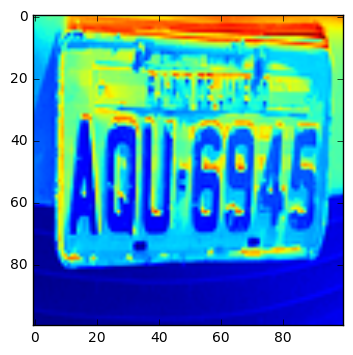

[ 85.36746216  76.68677521   9.97026825   9.25413704]
(86, 76)


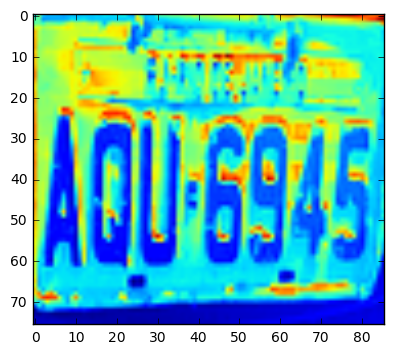

In [24]:
outPutSize = (100.0,100.0)
orgionalSize = 100.0

def scaleNumbers(w,h,x,y):
    factor =  outPutSize[0]/orgionalSize
    return (int(factor*x), int(factor*y), int(factor*w+(factor*x)), int(factor*h+(factor*y)))

img = getImage('example3.jpg')
A = np.expand_dims(np.expand_dims(np.asarray(img),axis=0), axis=0)/255.0

plt.imshow(A[0][0])
plt.show()

license_crop = segModel.predict(A)[0]
print license_crop

# display cropped license plate
img = img.crop(scaleNumbers(license_crop[0],license_crop[1],license_crop[2],license_crop[3]))
print img.size
plt.imshow(img)
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:121: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[  1.   0.  27.  17.  58.]
 [  1.  16.  29.  14.  57.]
 [  1.  29.  29.  18.  56.]
 [  0.  44.   0.   4.   0.]
 [  1.  46.  30.  16.  54.]
 [  1.  61.  31.  13.  53.]
 [  1.  73.  33.  13.  50.]
 [  1.  85.  29.  14.  57.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


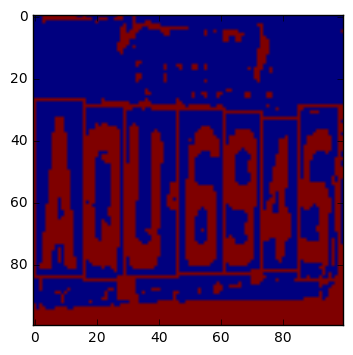

In [25]:
x_dim = 100
y_dim = 100

def is_upper_outlier(value, p25, p75):
    """Check if value is an outlier
    """
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return value >= upper

def is_lower_outlier(value, p25, p75):
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return value <= lower
    
def get_indices_of_outliers(values):
    """Get outlier indices (if any)
    """
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values, 75)
     
    indices_of_upper_outliers = []
    indices_of_lower_outliers = []
    for ind, value in enumerate(values):
        if is_upper_outlier(value, p25, p75):
            indices_of_upper_outliers.append(ind)
        elif is_lower_outlier(value, p25, p75):
            indices_of_lower_outliers.append(ind)
    return indices_of_lower_outliers, indices_of_upper_outliers

def find_clean_slice(img_arr):
    # create empty buckets for binary count on x & y dimensions
    y_bins = np.zeros(y_dim)
    x_bins = np.zeros(x_dim)
    
    # find a slice above or below y=60 at which a clean horizontal slice
    # can be taken. y=60 is the approximate center for characters in a well
    # segmented plate. this is to determine where values can be bucketed
    # along the x-axis with minimal background interference
    thresh = 15  # threshold for determing if slice is 'clear'
    slice_end = 0 # vertical point of clear horizontal slice
    slice_start = 60
    for y_i in range(y_dim / 2):
        # traverse upward
        up_offset = slice_start - y_i - 1
        slice_score = np.sum(img_arr[up_offset][:])
        if slice_score < thresh:
            slice_end = up_offset
            break

        # traverse downward, spill over once y_i == 100
        down_offset = (slice_start + y_i) % y_dim
        slice_score = np.sum(img_arr[down_offset][:])
        if slice_score < thresh:
            slice_end = down_offset
            break
            
    if slice_end < slice_start:
        # the clear slice was found in the upward travseral
        temp = slice_end
        slice_end = slice_start
        slice_start = temp
    
    return slice_start, slice_end

def gen_x_bins(img_arr, slice_start, slice_end):
    x_bins = np.zeros(x_dim)
    for x_i in range(len(x_bins)):
        # bin horizontal binary values between slice start and end
        x_bins[x_i] = np.sum(row[x_i] for row in img_arr[slice_start:slice_end])
    return x_bins 

def find_horiz_segs(x_bins, candidates):
# find free space to determine horizontal boundaries between characters
# start in center and work left and right to avoid edge noise
    vert_thresh = 0  # min bin count to determine a boundary between chars
    width_thresh = 3 # min character width
    width_ctr = 0    # ctr for width of current candidate char
    ctr = 0
    for x_i in range(x_dim):
        if x_bins[x_i] > 0 and x_i != x_dim - 1:          
            width_ctr = width_ctr + 1
            if not candidates[ctr][0] and x_bins[x_i] > vert_thresh:
                # only consider as a candidate if vert_thresh exceeded
                candidates[ctr][0] = True
        elif width_ctr != 0:
            # end of candidate segment
            if width_ctr >= width_thresh:
                # new segment found, set horizontal data
                x_start = x_i - width_ctr + 1
                candidates[ctr][1] = x_start
                candidates[ctr][3] = width_ctr     
                ctr = ctr + 1                        
            else:
                # candidate segment did not mneet horiz_thresh requirement
                candidates[ctr][0] = False
            width_ctr = 0
    return ctr

def spread_segs_vertical(candidates, slice_start, slice_end):
    # create empty buckets for binary count on x & y dimensions
        y_bins = np.zeros(y_dim)
        # calculate vertical data for segment
        height_thresh = 20
        if slice_start == 60:
            # invert loop to increase odds of early return
            slice_start = slice_end
            slice_end = -1
            incr = -1
        else:
            slice_end = 100 
            incr = 1
        for c in range(ctr):
            # loop thru candidates as found for horizontal segmenting and bin
            # vertical data
            height_ctr = 0
            for y_i in range(slice_start, slice_end, incr):
                # bin vertical data
                x_start = candidates[c][1]
                width = candidates[c][3]
                y_bins[y_i] = np.sum(img_arr[y_i][x_start:(x_start + width + 1)])
                #if y_bins[y_i] == 0 and y_b:
                    # TODO, implement early return
                    # early return if clear slice found after a given segment
                    # break

            # find start and ends for vertical data            
            seg_end = y_i + 1 if slice_end > slice_start else y_i - 1
            candidates[c][0] = False
            for y_ii in range(slice_start, seg_end, incr):
                if y_bins[y_ii] > 0 and y_ii != y_i:
                    height_ctr = height_ctr + 1
                elif height_ctr != 0:
                    # end of candidate segment
                    if height_ctr > height_thresh:
                        # candidate was successfully found
                        candidates[c][0] = True
                        candidates[c][2] = y_ii - height_ctr if slice_start < seg_end else y_ii
                        candidates[c][4] = height_ctr
                        break
                    elif y_ii == y_i:
                        # final itr in loop, no valid vertical segmentation found
                        candidates[c][0] = False
                    height_ctr = 0   

def merge_segs(candidates, c_indexes):
    width_thresh = 6
    dist_thresh = 10
    # merge neighboring boxes that are of insufficient width or height
    for i in range(len(c_indexes) - 1):
        c_i = c_indexes[i]
        neighbor = c_indexes[i+1]

        if candidates[c_i][3] < width_thresh and candidates[neighbor][3] < width_thresh:
            lhs = candidates[c_i][1]
            rhs = lhs + candidates[c_i][3] - 1
            n_lhs = candidates[neighbor][1]
            n_rhs = n_lhs + candidates[neighbor][3] - 1
            top = candidates[c_i][2]
            n_top = candidates[neighbor][2]
            btm = n_top + candidates[c_i][4] - 1
            n_btm = top + candidates[neighbor][4] - 1
            while rhs < n_lhs:
                # push left neighbor toward right neighbor until whitespace found
                if np.sum(row[rhs] for row in img_arr[top:btm]) > 0:
                    rhs += 1
                else:
                    break
            if rhs == n_lhs:
                # connect segments
                new_top = min(top, n_top)
                new_width = n_rhs - lhs + 1
                new_height = max(btm, n_btm) + 1 - new_top
                candidates[c_i][2] = new_top
                candidates[c_i][3] = new_width
                candidates[c_i][4] = new_height
                candidates[neighbor][0] = False
                c_indexes[i+1] = c_indexes[i]

        
def select_segs(candidates, c_indexes):
    # choose boxes 
    c_ctr = 0 
    
    """if len(c_indexes) == 7:
        # no false data segments, copy blindly to output
        for c_i in enumeratec_indexes:
            chars[img_ctr][c_ctr] = candidates[c_i]
            c_ctr += 1"""
    if len(c_indexes) < 7:
        # break any boxes that are too wide
        widths = [row[3] for row in candidates[c_indexes]]
        lower_os, upper_os = get_indices_of_outliers(widths)
        for o in upper_os:
            new_i = c_indexes[-1] + 1
            if new_i > 19:
                # lazy error, this case unlikely but possible
                print 'ERROR OVERFLOW'
            else:
                if c_indexes[o] == c_indexes[-1]:
                    c_indexes.append(new_i)
                else:
                    # do not add to end, next block of code depends on last element
                    # being rightmost character
                    c_indexes.insert(o+1, new_i)
                new_width = candidates[c_indexes[o]][3] / 2
                candidates[new_i][0] = True
                candidates[new_i][1] = candidates[c_indexes[o]][1] + new_width 
                candidates[new_i][2] = candidates[c_indexes[o]][2]
                candidates[new_i][3] = new_width
                candidates[new_i][4] = candidates[c_indexes[o]][4]
                candidates[c_indexes[o]][3] = new_width     
    elif len(c_indexes) > 7:
        # filter for most probable segments by height
        heights = [row[4] for row in candidates[c_indexes]]
        lower_os, upper_os = get_indices_of_outliers(heights)
        for o in upper_os:
            candidates[c_indexes[o]][0] = False
            for indx, l_o in enumerate(lower_os):
                if l_o > o:
                    lower_os[indx] = l_o - 1
            del c_indexes[o]            
        for o in lower_os:
            candidates[c_indexes[o]][0] = False
            del c_indexes[o]    
    
def expand_segs(candidates, c_indexes):
    # expand boxes left, right, up and down. Expansion will not be performed
    # in full if only a single box was segmented
    if len(c_indexes) != 0:
        # expand 1st box to left by 6
        x = candidates[c_indexes[0]][1]
        upd_x = max(0, x - 6)
        candidates[c_indexes[0]][1] = upd_x
        candidates[c_indexes[0]][3] = x - upd_x + candidates[c_indexes[0]][3]
        
        # expand last box to right by 6
        x = candidates[c_indexes[-1]][1]
        upd_rhs = min(99, x + candidates[c_indexes[-1]][3] + 5 - 1)
     
        candidates[c_indexes[-1]][3] = upd_rhs - x
        
        # expand last box up by 5
        y = candidates[c_indexes[-1]][2]
        upd_y = max(0, y - 5)
        candidates[c_indexes[-1]][2] = upd_y
        candidates[c_indexes[-1]][4] = y - upd_y + candidates[c_indexes[-1]][4]
        
        # expand last box down by 5
        upd_btm = min(99, upd_y + candidates[c_indexes[-1]][4] + 5 - 1)
        candidates[c_indexes[-1]][4] = upd_btm - upd_y

    for i in range(len(c_indexes) - 1):
        c_i = c_indexes[i]
        neighbor = c_indexes[i+1]
        # expand box to right and neighbor to left with 'overlap' px of overlap.
        overlap = 0
        dist = candidates[neighbor][1] - candidates[c_i][1] - candidates[c_i][3] + 1
        intersect = candidates[neighbor][1] - (dist // 2)
        candidates[c_i][3] = (intersect + overlap) - candidates[c_i][1] + 1
        candidates[neighbor][3] = candidates[neighbor][3] + candidates[neighbor][1] - (intersect - overlap)
        candidates[neighbor][1] = intersect - overlap
        
        # expand box up by 5
        y = candidates[c_i][2]
        upd_y = max(0, y - 5)
        candidates[c_i][2] = upd_y
        candidates[c_i][4] = y - upd_y + candidates[c_i][4]
        
        # expand box down by 5
        upd_btm = min(99, upd_y + candidates[c_i][4] + 5 - 1)
        candidates[c_i][4] = upd_btm - upd_y
    
def view_segs(img_arr, candidates, c_indexes):
    # view result
    print candidates
    px_val = 2
    for c_i in c_indexes:
        px_val = 2 if px_val != 2 else 3
        x = int(candidates[c_i][1])
        y = int(candidates[c_i][2])
        width = int(candidates[c_i][3])
        height = int(candidates[c_i][4])

        for i in range(x, x + width):
            # draw horizontals
            img_arr[y][i] = px_val
            img_arr[y+height-1][i] = px_val
        for j in range(y, y + height):
            # draw verticals             
            img_arr[j][x] = px_val
            img_arr[j][x+width-1] = px_val
    plt.imshow(img_arr)
    plt.show()

#
# ACTUAL REAL LIVE CODE!
#
img = img.resize((100,100), PIL.Image.ANTIALIAS)

bin_thresh = np.mean(img) - 15
bin_img = img.point(lambda x: 255 if x<bin_thresh else 0, '1')

img_arr = np.asarray(bin_img)
img_arr.flags.writeable = True

# arr of all candidate segments. updated throughout process.
# [segments][found?, x, y, width, height]    
candidates = np.zeros([20, 5]) 

# find a horizontal slice within center of image that begins
# within letter portion of plate and ends just above or below
slice_start, slice_end = find_clean_slice(img_arr)

# bin horizontal data within the slice
x_bins = gen_x_bins(img_arr, slice_start, slice_end)

# use bin to determine potential segments
ctr = find_horiz_segs(x_bins, candidates)

# stretch segments vertically to determine. drops segments
# which are too short.
spread_segs_vertical(candidates, slice_start, slice_end)

# get indexes of successful segments as mapped to candidates
c_indexes = [i for i, x in enumerate(candidates) if x[0]]

# search for neighboring segments that are thin and connected 
merge_segs(candidates, c_indexes)

# remove redundancies in c_indexes map generated by merging
c_indexes = list(set(c_indexes))

# select the 7 most probable segments
select_segs(candidates, c_indexes)

# expand those segments in a way that allows for partial overlap,
# reducing the likelihood of a partially segmented letter. 
expand_segs(candidates, c_indexes)

# output the result with segmented boxes projected over binary image
view_segs(img_arr, candidates, c_indexes)

imageData = np.expand_dims(np.empty([100,100]), axis=0)
for ind, c_i in enumerate(c_indexes):
    w = candidates[c_i][3]
    h = candidates[c_i][4]
    x = candidates[c_i][1]
    y = candidates[c_i][2]
    new_img = img.crop(scaleNumbers(w,h,x,y))
    new_img = new_img.resize((100,100), PIL.Image.ANTIALIAS)
    imageData = np.concatenate((imageData, np.expand_dims(np.asarray(new_img),axis=0)), axis = 0)
    
imageData = imageData[1:]           #These two lines get ride of the garbage that was
    
#imageData = np.expand_dims(np.empty([100,100]), axis=0)
#img = changImageSize(fileName)
#    imageData = np.concatenate((imageData, np.expand_dims(np.asarray(img) ,axis=0)), axis=0)